# TUTORIAL: LIMPIEZA DE IMÁGENES CON AUTOENCODERS

Contenido:

1. [El problema a resolver](#scrollTo=x9QccXfnZyXZ&line=6&uniqifier=1)
2. [El set de datos](#scrollTo=0b_iSuY7AfEW&line=15&uniqifier=1)
3. [Creación y entrenamiento del autoencoder](#scrollTo=4cI6cCd1T90u&line=29&uniqifier=1)
4. [Prueba del autoencoder](#scrollTo=o1f5xf0qO912)

## 1. El problema a resolver

El objetivo de este tutorial es entrenar y poner a prueba un autoencoder capaz de atenuar el ruido presente en una imagen:

![](https://drive.google.com/uc?export=view&id=1nv0riyWxwPnNR6dyTp_vYjOGNEnE5Zy-)


## 2. El set de datos

Usaremos un set de datos que contiene imágenes tanto contaminadas por ruido como imágenes ideales.

Este set de imágenes está divido en dos partes: entrenamiento y prueba.

El **set de entrenamiento** contiene 144 imágenes con ruido y por cada una de estas imágenes se tiene una imagen ideal:

![](https://drive.google.com/uc?export=view&id=1nvNMdCLn7wZhXWHo85EGd5cLXnMRZ4pr)

Estas imágenes serán usadas para entrenar el autoencoder el cual **aprenderá a reconstruir la imagen sin ruido**.

El **set de prueba** contiene 72 imágenes, diferentes de las de entrenamiento, que contienen ruido:

![](https://drive.google.com/uc?export=view&id=1nvkBL05NnrpmjH6iPbt_PlzYwZlJJBvs)

Estas imágenes serán usadas para **poner a prueba el autoencoder ya entrenado**, es decir para verificar si logra atenuar/eliminar el ruido en imágenes que nunca ha visto.

## 2.1. Lectura del set de datos

Comencemos descargando los sets de datos (archivo [noisy_documents.zip](https://drive.google.com/file/d/1RV7PIxtmphTaY5pqNAKI9tE7WOoweH0S/view?usp=sharing)).

Una vez descargado localmente lo arrastramos al disco de la máquina virtual de Google Colab.

El siguiente paso es descomprimir este archivo:

In [1]:
# Descomprimir "noisy_documents.zip"
!unzip -q "/content/noisy_documents.zip"

Tras ejecutar la línea anterior deberíamos encontrar tres carpetas en el disco duro de la máquina virtual:

- `train_clean`: imágenes de entrenamiento sin ruido
- `train_noise`: imágenes de entrenamiento con ruido
- `test`: imágenes de prueba

El siguiente paso es leer estas imágenes desde el disco duro de la máquina virtual hasta la memoria RAM de Google Colab.

Para esto crearemos un [dataset de tensorflow](https://youtu.be/RhxI4Z7C0YU) con ayuda de la función `image_dataset_from_directory` que nos permite realizar la lectura de las imágenes y almacenarlas en variables tipo `Dataset`:

In [2]:
# Crear datasets tensorflow
import tensorflow as tf

# Imágenes con ruido
x_train = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/train_noise',
    labels = None, # Imágenes sin etiquetas
    color_mode='grayscale', # Imágenes en escala de griz
    batch_size = 32, # Organizar imágenes en lotes de 32 imágenes
    image_size=(540, 258), # Tamaño original de cada imagen
    shuffle=False, # NO mezclarlas aleatoriamente
)

# Imágenes sin ruido
y_train = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/train_clean',
    labels=None,
    color_mode='grayscale',
    batch_size = 32,
    image_size=(540, 258),
    shuffle=False,
)

# Imágenes de prueba (con ruido)
test = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels=None,
    color_mode='grayscale',
    batch_size = 32,
    image_size=(540, 258),
    shuffle=False,
)

# Imprimir información de los datasets
print(f'x_train: {type(x_train)}')
print(f'y_train: {type(y_train)}')
print(f'test: {type(test)}')

Found 144 files belonging to 1 classes.
Found 144 files belonging to 1 classes.
Found 72 files belonging to 1 classes.
x_train: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
y_train: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
test: <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


En las líneas de código anterior hemos especificado el parámetro `labels` como `None` para indicar que sólo vamos a usar imágenes mas no categorías.

Además hemos definido el parámetro `batch_size` con un valor de 32 para indicarle a TensorFlow que tanto durante el entrenamiento como para la generación de predicciones con el autoencoder usaremos lotes de 32 imágenes.

Finalmente, es clave fijar de manera explícita el parámetro `shuffle` como falso (`False`). De esta manera, al crear los sets de datos TensorFlow preservará el orden de las imágenes según el nombre de cada archivo dentro de las respectivas carpetas. Esto es clave para lograr preservar la relación entre las imágenes que usaremos durante el entrenamiento tanto a la entrada como a la salida del autoencoder (variables `x_train` y `y_train`).

## 2.2. Exploración del set de datos

Muy bien, habiendo explorado el set de datos hagamos una exploración del mismo.

Comencemos visualizando algunos ejemplos del set de entrenamiento. Para ello:

1. Tomaremos un lote (de 32 imágenes, correspondientes al parámetro `batch_size` especificado anteriormente) del set de entrenamiento (`x_train`, `y_train`). Para tomar este lote usaremos el método `take`
2. De dicho lote tomaremos una imagen cualquiera especificada por el índice `idx`
3. Finalmente mostraremos la imagen contaminada por ruido (proveniente de `x_train`) y la imagen ideal (proveniente de `y_train`) con ayuda de la función `imshow()` de la librería Matplotlib.

Veamos esta implementación:

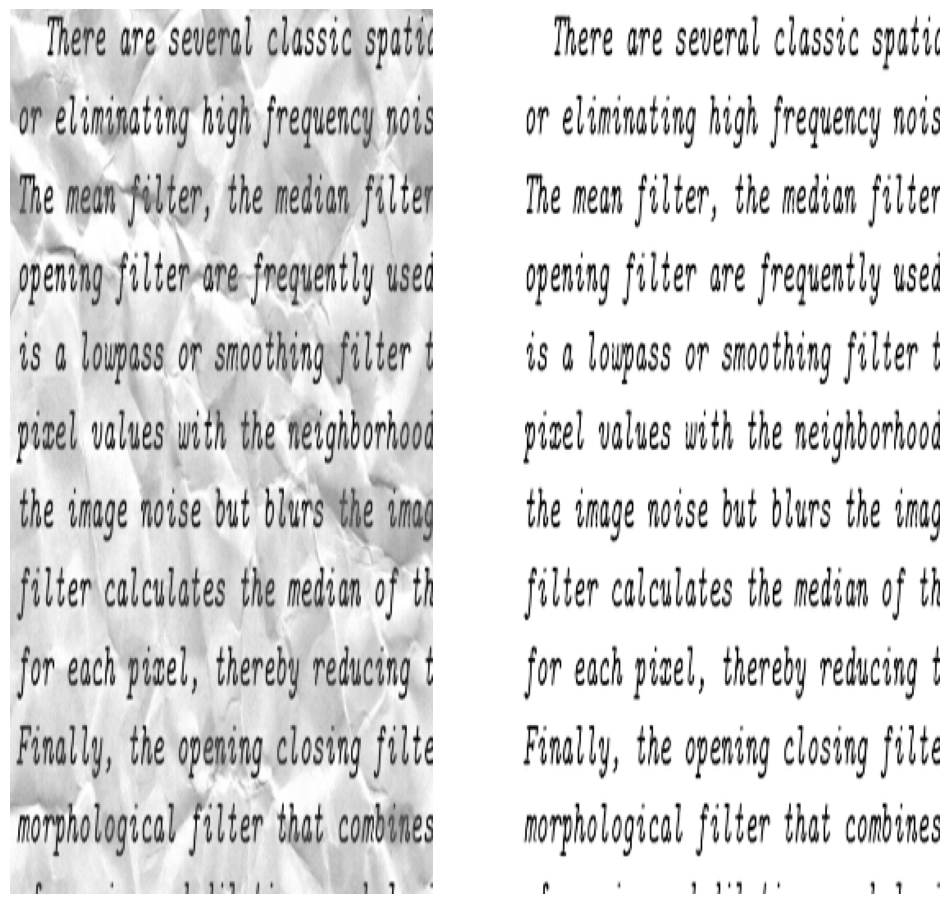

In [4]:
# Dibujar imágenes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for img_in, img_out in zip(x_train.take(1), y_train.take(1)):

    # Índice imagen dentro del lote (<=31)
    idx = 23

    # Imagen con ruido
    plt.subplot(1,2,1)
    plt.imshow(img_in[idx].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

    # Imagen ideal
    plt.subplot(1,2,2)
    plt.imshow(img_out[idx].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

Y ahora hagamos algo similar a lo anterior pero para mostrar una imagen cualquiera proveniente del set de prueba.

En este caso no tendremos pares de imágenes ya que el set de prueba sólo contiene imágenes contaminadas con ruido.

El código es muy similar al del caso anterior: de nuevo usaremos `take()` para tomar un lote de imágenes junto con `imshow()` para mostrar una imagen de dicho lote:

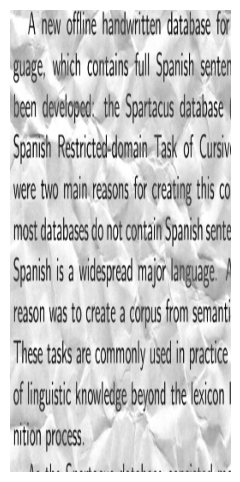

In [5]:
# Mostrar imagen prueba
plt.figure(figsize=(6, 6))
for img_tst in test.take(1):

    # Índice imagen dentro del lote (<=31)
    idx = 8

    # Imagen con ruido
    plt.imshow(img_tst[idx].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

Perfecto, podemos ver que las imágenes contaminadas por ruido se caracterizan porque el fondo tiene patrones relativamente aleatorios que dificultan la lectura del texto.

El reto, como veremos más adelante, será lograr entrenar un autoencoder que aprenda a identificar la información relevante en las imágenes con ruido (es decir el texto) y aprenda a reconstruir la imagen sin dicho componente.

Para terminar con esta exploración tomemos la imagen del set de prueba mostrada anteriormente e imprimamos en pantalla su tamaño (usando el atributo `shape`) así como los valores máximo y mínimo de sus píxeles (usando los métodos `min()` y `max()` de NumPy).

Es clave tener en cuenta que antes de usar estos atributos/métodos debemos convertir la imagen (que es un tensor de TensorFlow) en un arreglo de NumPy, haciendo uso del método `numpy()`.

Este sería el código completo:

In [6]:
# Imprimir en pantalla características de una imagen
print(img_tst[idx].numpy().shape)
print(img_tst[idx].numpy().min())
print(img_tst[idx].numpy().max())

(540, 258, 1)
0.10464318
255.0


En este punto podemos ver que cada imagen tiene un tamaño de 540 filas por 248 columnas y que los valores de los pixeles oscilan entre 0 y 255.

Esta última observación es importante, pues implica que antes de presentar las imágenes al autoencoder tendremos que hacer un escalamiento de sus pixeles para llevarlos del rango de 0-255 al rango de 0-1. Esto debido a que los modelos de Deep Learning (como los autoencoders) son entrenados adecuadamente cuando los datos han sido escalados a este tipo de rangos.

## 2.3. Pre-procesamiento de los sets de datos

En esta fase tenemos que ajustar los datos al formato requerido por el autoencoder que implementaremos más adelante.

El primer ajuste que debemos llevar a cabo es el escalamiento mencionado anteriormente.

Para lograr esto haremos uso del módulo `Rescaling` de la librería TensorFlow/Keras.

El módulo `Rescaling` nos permite tomar cada dato y aplicar una operación a nivel de pixeles. En este caso la operación consiste simplemente en dividir cada pixel entre 255, logrando así que el rango de valores original (entre 0 y 255) pase a ser ahora de 0 a 1 en las imágenes resultantes.

Comencemos creando esta capa de escalamiento:

In [7]:
# Crear capa de escalamiento
capa_escalamiento = tf.keras.layers.Rescaling(1./255)

Y ahora simplemente podemos usar el método `map` para aplicar esta capa a cada uno de los sets de datos leídos anteriormente (`x_train`, `y_train`, `test`):

In [8]:
# Escalar y sobre-escribir cada set de datos
x_train = x_train.map(lambda x: capa_escalamiento(x))
y_train = y_train.map(lambda x: capa_escalamiento(x))
test = test.map(lambda x: capa_escalamiento(x))

En las líneas de código anteriores hemos usado como argumento del método `map` el siguiente código:

`lambda x: capa_escalamiento(x)``

La palabra clave `lambda` en Python nos permite crear una "función lambda" que es simplemente una función de una sola línea, muy compacta, que aplicaremos a cada dato dentro de los sets `x_train`, `y_train` y `test`.

En este caso la función lambda:

1. Tomará cada imagen (`x`) dentro del set de datos (`lambda x:`)
2. Y le aplicará el escalamiento definido en la capa `Rescaling` que definimos anteriormente (`capa_escalamiento(x)`)

El resultado de esto es que cada imagen en cada set de datos tendrá ahora sus pixeles en el rango de 0 a 1, adecuados para poder entrenar y generar predicciones más adelante con el autoencoder.

Para verificar que este escalamiento funciona de la forma esperada podemos:

1. Usar `take()` para tomar un lote de imágenes de cada set de datos
2. Tomar una imagen de cada lote
3. Convertirla a un arreglo de NumPy usando el método `numpy()` y
4. Usar los métodos `min()` y `max()` para imprimir en pantalla los valores máximos y mínimos

Esta sería la implementación:

In [9]:
# Verificar
for batch1, batch2, batch3 in zip(x_train.take(1), y_train.take(1), test.take(1)):
    img1, img2, img3 = batch1[0].numpy(), batch2[0].numpy(), batch3[0].numpy()

    print(f'x_train: {img1.min()}, {img1.max()}')
    print(f'y_train: {img2.min()}, {img2.max()}')
    print(f'test: {img3.min()}, {img3.max()}')

x_train: 0.009533843025565147, 0.9928613305091858
y_train: 0.0, 1.0
test: 0.05815816670656204, 0.9400539398193359


Y lo anterior nos permite verificar que ahora las imágenes en los sets de entrenamiento y prueba tienen pixeles en el rango deseado (0 a 1).

Ahora debemos enfocarnos en un segundo tipo de transformación: el agrupamiento de los datos de entrenamiento.

Durante el entrenamiento debemos presentar al modelo pares de imágenes provenientes de los sets `x_train` (imágenes con ruido) y `y_train` (imágenes ideales): las primeras se usarán como entrada del autoencoder, mientras que las segundas se le presentarán al modelo como referencia para que aprenda a generar progresivamente imágenes sin ruido.

Sin embargo, las imágenes de entrenamiento se encuentran en variables diferentes (`x_train` y `y_train`) y debemos combinarlas en un mismo Dataset de Tensorflow para poder entrenar el modelo.

Además, debemos garantizar que se preserva la relación uno a uno entre dichas imágenes, es decir que cada dato del set combinado contendrá dos imágenes que sólo pueden diferir en la presencia o ausencia de ruido, pero el texto **debe ser exactamente el mismo**.

Todo esto lo podemos lograr de manera muy simple usando el método `zip`:

In [10]:
# Agrupar "x_train" y "y_train" en un mismo dataset
train = tf.data.Dataset.zip((x_train, y_train))
print(type(train))

<class 'tensorflow.python.data.ops.zip_op._ZipDataset'>


Con lo anterior tendremos un único dataset de entrenamiento (la variable `train`) con las características deseadas.

Verifiquemos que al iterar sobre este set de datos obtendremos pares de imágenes.

Para esto usaremos simplemente un bloque `for` y en cada iteración obtendremos dos lotes:

- `x`: el lote de imágenes de entrada (imágenes con ruido)
- `y`: el lote de imágenes de salida (imágenes sin ruido)

Implementemos este código y en cada iteración imprimamos en pantalla el tamño de cada lote:

In [11]:
for x, y in train:
  print(x.shape, y.shape)

(32, 540, 258, 1) (32, 540, 258, 1)
(32, 540, 258, 1) (32, 540, 258, 1)
(32, 540, 258, 1) (32, 540, 258, 1)
(32, 540, 258, 1) (32, 540, 258, 1)
(16, 540, 258, 1) (16, 540, 258, 1)


Vemos que al imprimir estos tamaños tenemos una perfecta equivalencia entre los lotes:

- Del lado izquierdo (datos de entrada) tendremos un total de 5 lotes, los 4 primeros con 32 datos y el último con 16 (sumando así el total de 144 datos)
- Y del lado derecho tendremos lotes exactamente del mismo tamaño

Sin embargo, lo anterior no nos garantiza que se mantendrá la relación uno a uno entre imágenes con ruido e imágenes sin ruido.

Para poder verificar esto:

1. Tomaremos un lote del set de entrenamiento usando el método `take`. Este lote tendrá dos subsets que llamaremos `X` (lote de imágenes con ruido) y `Y` (lote de imágenes sin ruido)
2. Luego definiremos un índice (`idx`) que nos permitirá tomar una imagen cualquiera dentro de `X` y `Y`. Llamaremos a estas imágenes resultantes `x` y `y`
3. Y finalmente usaremos `imshow` para mostrar las imágenes `x` y `y` y verificar que contienen el mismo texto y difieren únicamente en el fondo


Implementemos este código y hagamos la prueba con diferentes valores de `idx`:

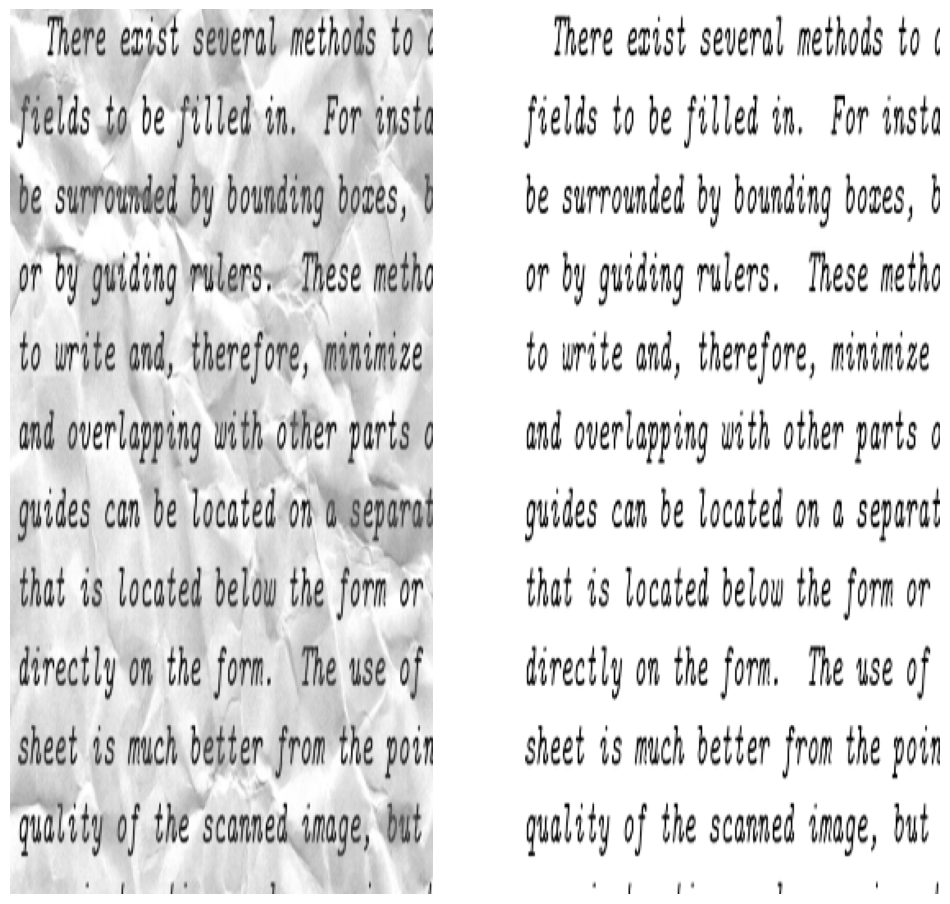

In [13]:
# Tomar un batch y dibujar una imagen
plt.figure(figsize=(12, 12))
for X, Y in train.take(1):
    # Tomar una imagen de cada lote
    idx = 22
    x, y = X[idx], Y[idx]

    # Entrada (imagen con ruido)
    plt.subplot(1,2,1)
    plt.imshow(x.numpy(), cmap="gray")
    plt.axis("off")

    # Salida (imagen ideal)
    plt.subplot(1,2,2)
    plt.imshow(y.numpy(), cmap="gray")
    plt.axis("off")

¡Perfecto!

En este punto ya hemos pre-procesado correctamente las imágenes.

Ya estamos listos para construir el autoencoder.

## 3. Creación y entrenamiento del autoencoder

En un tutorial anterior vimos en detalle el principio de funcionamiento de un autoencoder. Recordemos los principales elementos a tener en cuenta:

1. El autoencoder es una arquitectura que entrenaremos para que aprenda a generar el mismo dato de entrada. Llamaremos a esta predicción generada por el modelo la **reconstrucción**

![](https://drive.google.com/uc?export=view&id=1nwaPACDOY1VM971VNJu6qWn7dwJs6Dnp)

2. Para ello el autoencoder tendrá tres elementos básicos:
    - El **encoder** que consiste en una serie de capas (neuronales, convolucionales, etc.)
    - El **bottleneck** que es simplemente la salida del **encoder** y que es una representación compacta del dato de entrada y que tiene una dimensionalidad (tamaño) menor que el dato de entrada
    - El **decoder** que realiza el proceso inverso del **encoder**: un conjunto de capas (neuronales, convolucionales, etc.) toma la representación compacta y aprende a reconstruir el dato original

![](https://drive.google.com/uc?export=view&id=1nxyfbjPUUYG1pbL-vTHvsU8sE3Qfsoo4)


### 3.1. Implementación del autoencoder

Teniendo en cuenta que procesaremos imágenes, usaremos un autoencoder basado en Redes Convolucionales (o simplemente un "autoencoder convolucional"). Esto quiere decir que los elementos tanto del encoder como del decoder estarán basados en capas convolucionales.

En particular, este autoencoder convolucional tendrá estas características:

- **Capa de entrada**: aceptará imágenes en escala de gris de 540x258 pixeles
- **Encoder**: tendrá una capa convolucional con 64 filtros, de tamaño 3x3 cada uno y función de activación "ReLU", seguida de una capa de Max-Pooling de tamaño 2x2
- **Decoder**: usará una capa convolucional de 64 filtros, de tamaño 3x3 cada uno (idéntica a la capa usada en el encoder) y para reconstruir el dato usaremos una capa tipo *UpSampling2D* que permitirá generar una imagen reconstruida del mismo tamaño de la imagen original
- **Capa de salida**: para generar la imagen de salida (la "reconstrucción") usaremos una capa convolucional con un sólo filtro (para generar imágenes en escala de grises) de tamaño 3x3. Esta capa debe tener una función de activación tipo sigmoidal, para garantizar que los pixeles generados estarán en el rango de 0 a 1 (el mismo rango de las imágenes de entrada)

![](https://drive.google.com/uc?export=view&id=1o0I2Zj9sSgIM9bywNd5okTQBgNH5hwQd)

Veamos entonces cómo implementar este autoencoder. Comencemos fijando la semilla del generador aleatorio para garantizar la reproducibilidad del entrenamiento:

In [14]:
tf.random.set_seed(123)

Y ahora definamos uno a uno los elementos mencionados anteriormente:

In [15]:
# Entrada
entrada = tf.keras.layers.Input(shape=(540,258,1), name="entrada")

# Encoder
x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", name="conv_encoder")(entrada)
x = tf.keras.layers.MaxPooling2D((2,2), padding="same", name="maxpool_encoder")(x)

# Decoder
x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_decoder")(x)
x = tf.keras.layers.UpSampling2D((2,2), name="upsampling_decoder")(x)

# Salida
salida = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding="same", name="salida")(x)

# Autoencoder
autoencoder = tf.keras.Model(entrada, salida)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 540, 258, 1)]     0         
                                                                 
 conv_encoder (Conv2D)       (None, 540, 258, 64)      640       
                                                                 
 maxpool_encoder (MaxPoolin  (None, 270, 129, 64)      0         
 g2D)                                                            
                                                                 
 conv_decoder (Conv2D)       (None, 270, 129, 64)      36928     
                                                                 
 upsampling_decoder (UpSamp  (None, 540, 258, 64)      0         
 ling2D)                                                         
                                                                 
 salida (Conv2D)             (None, 540, 258, 1)       577   

Y acá podemos entender la lógica del encoder y del decoder:

- El encoder tomará una entrada (capa *entrada*) de 540x258 y generará un volumen de 270x129x64 (capa *maxpool_encoder*)
- El decoder tomará el volumen anterior, incrementará su tamaño a 540x258x64 (capa *upsampling_encoder*) y finalmente generará la imagen de salida con un tamaño de 540x258 (capa *salida*)

Verifiquemos que tanto la entrada como la salida tienen exactamente el mismo tamaño:

In [16]:
# Verificar que la entrada y la salida son del mismo tamaño
print(f'Autoencoder - dimensiones entrada: {autoencoder.input_shape}')
print(f'Autoencoder - dimensiones salida: {autoencoder.output_shape}')

Autoencoder - dimensiones entrada: (None, 540, 258, 1)
Autoencoder - dimensiones salida: (None, 540, 258, 1)


### 3.2. Entrenamiento del autoencoder

Muy bien, habiendo creado el autoencoder podemos enfocarnos en el entrenamiento.

Primero debemos compilar el modelo, es decir definir la pérdida y el optimizador.

Recordemos que el entrenamiento permite calcular automáticamente los parámetros que generarán las mejores predicciones posibles. Para ello:

1. Se toman las imagénes de entrenamiento con ruido y se presentan al modelo generando, por cada imagen de entrada, una reconstrucción
2. Se usa la **pérdida** para comparar la reconstrucción generada por el autoencoder con su correspondiente imagen ideal (sin ruido)
3. El promedio de las pérdidas se presenta al **algoritmo de optimización** que ajusta automáticamente los parámetros reduciendo la pérdida
4. Se repiten los pasos 1 a 3 por el número de iteraciones que especifiquemos

Así que debemos definir la **pérdida** que usaremos así como el algoritmo de optimización.

Como pérdida usaremos el error cuadrático medio (*mse* o *mean squared error*) que se calcula simplemente como:

$$mse = promedio((\hat{y}-y)^2)$$

donde $\hat{y}$ es cada una de las imágenes reconstruidas por el autoencoder y $y$ es la imagen ideal (sin ruido, tomada del set de entrenamiento).

Y como optimizador usaremos el Algoritmo Adam (similar al Gradiente Descendente pero que requiere menos iteraciones).

Y todo esto lo podemos definir en una sola línea de código usando el método `compile`. En este método definiremos la pérdida como `loss = "mse"` y el optimizador usando el argumento `optimizer = "adam"`:

In [17]:
autoencoder.compile(optimizer = "adam", loss = "mse")

Y ya estamos listos para realizar el entrenamiento.

Para ello usaremos el método `fit` con los siguientes argumentos y simplemente debemos
presentar los siguientes parámetros:

- El set de entrenamiento (variable `train`)
- `epochs = 50` para llevar a cabo 50 iteraciones

Nno es necesario definir por ejemplo tamaño del lote pues este ya está definido como parte del set de entrenamiento.

Por tratarse de imágenes relativamente grandes, y de un modelo convolucional, se sugiere hacer uso de la GPU de Google Colab:

In [18]:
autoencoder.fit(train, epochs=50)

Epoch 1/50
5/5 [==============================] - 16s 1s/step - loss: 0.1670
Epoch 2/50
5/5 [==============================] - 1s 202ms/step - loss: 0.0667
Epoch 3/50
5/5 [==============================] - 1s 203ms/step - loss: 0.0591
Epoch 4/50
5/5 [==============================] - 1s 205ms/step - loss: 0.0632
Epoch 5/50
5/5 [==============================] - 1s 209ms/step - loss: 0.0639
Epoch 6/50
5/5 [==============================] - 1s 205ms/step - loss: 0.0624
Epoch 7/50
5/5 [==============================] - 1s 205ms/step - loss: 0.0585
Epoch 8/50
5/5 [==============================] - 1s 204ms/step - loss: 0.0545
Epoch 9/50
5/5 [==============================] - 1s 204ms/step - loss: 0.0541
Epoch 10/50
5/5 [==============================] - 1s 208ms/step - loss: 0.0520
Epoch 11/50
5/5 [==============================] - 1s 205ms/step - loss: 0.0507
Epoch 12/50
5/5 [==============================] - 2s 225ms/step - loss: 0.0483
Epoch 13/50
5/5 [==============================] - 

¡Perfecto! En este punto ya hemos entrenado nuestro autoencoder. Sólo nos resta ponerlo a prueba.

## 4. Prueba del autoencoder

La idea en esta parte es verificar si efectivamente el autoencoder logra atenuar o eliminar por completo el ruido en las imágenes.

Para ello haremos dos pruebas. La primera consiste en verificar qué tan bien lo hace con las imágenes ya conocidas por el modelo (las de entrenamiento). Para ello:

1. Tomaremos diferentes imágenes con ruido provenientes del set de entrenamiento
2. Presentaremos estas imágenes al modelo entrenado y generaremos las predicciones (reconstrucciones) correspondientes
3. Mostraremos las imágenes originales (con ruido) y las reconstruidas (imágenes con ruido atenuado) y verificaremos la calidad de las imágenes obtenidas


Para facilitar la visualización crearemos la función `mostrar_imagenes` que:

- Tomará como entradas un dataset con imágenes originales (con ruido) y un arreglo con las correspondientes predicciones
- Tomará aleatoriamente 3 imágenes originales y reconstruidas y las mostrará en pantalla

Veamos cómo implementar esta función:

In [19]:
import numpy as np

def mostrar_imagenes(array1, array2):
    # Extraer imágenes
    n = 3 # Número de imágenes
    idx = np.random.randint(len(array1), size=n)
    imgs1 = array1[idx, :] # Imagen con ruido
    imgs2 = array2[idx, :] # Imagen predicha (reconstrucción)

    # Mostrar imágenes
    plt.figure(figsize=(20,16))
    for i, (img1, img2) in enumerate(zip(imgs1, imgs2)):
        # Mostrar imagen original (con ruido) arriba
        ax = plt.subplot(2,n,i+1)
        plt.imshow(img1, cmap='gray')
        plt.axis("off")

        # Y mostrar imagen reconstruida abajo
        plt.subplot(2,n,i+1+n)
        plt.imshow(img2, cmap='gray')
        plt.axis("off");

Ahora podemos probar el funcionamiento usando primero el set de entrenamiento.

En primer lugar tomemos un lote de dicho set:

In [21]:
batch = x_train.take(1) # Batch con 32 imágenes

Este *batch* contendrá 32 imágenes. Sin embargo es de tipo "Dataset" y la función que creamos hace un momento acepta arreglos de NumPy.

Convirtamos este *batch* a un arreglo de NumPy. Para ello:

- Usamos `unbatch()` para poder separar las 32 imágenes que hacen parte del lote
- Después aplicamos `as_numpy_iterator()` para poder extraer cada imagen
- A lo anterior aplicamos la función `list` de Python para poder iterar sobre cada imagen y almacenarla como un arreglo de NumPy en esa lista
- Finalmente usamos `np.array` para convertir el resultado anterior en un arreglo de NumPy

Todo lo anterior lo podemos implementar en una sola línea de código:

In [22]:
# Convertir el batch en un arreglo de NumPy y
# sobre-escribirlo
batch = np.array(list(batch.unbatch().as_numpy_iterator()))

Perfecto. Ahora tomamos este *batch* (que contiene 32 imágenes con ruido) y se lo presentamos al autoencoder entrenado usando el método `predict`.

Por cada imagen del *batch* se generará una predicción que, idealmente, debería corresponder a una imagen sin ruido.

Generemos estas predicciones y verifiquemos que los tipos de datos y los tamaños tanto del *batch* como de la predicción son los mismos:

In [23]:
# Batch de predicciones
y_pred = autoencoder.predict(batch)

# Imprimir tipos de dato
print(f'Tipos de dato batch/y_pred: {type(batch)}/{type(batch)}')
print(f'Tamaños batch/y_pred: {batch.shape}/{y_pred.shape}')

1/1 [==============================] - 0s 103ms/step
Tipos de dato batch/y_pred: <class 'numpy.ndarray'>/<class 'numpy.ndarray'>
Tamaños batch/y_pred: (32, 540, 258, 1)/(32, 540, 258, 1)


Muy bien, tanto el batch como las predicciones son Arreglos de NumPy, así que sólo nos resta llevarlos a la función `mostrar_imagenes` que creamos anteriormente para ver los resultados de la predicción en 3 imágenes aleatorias:

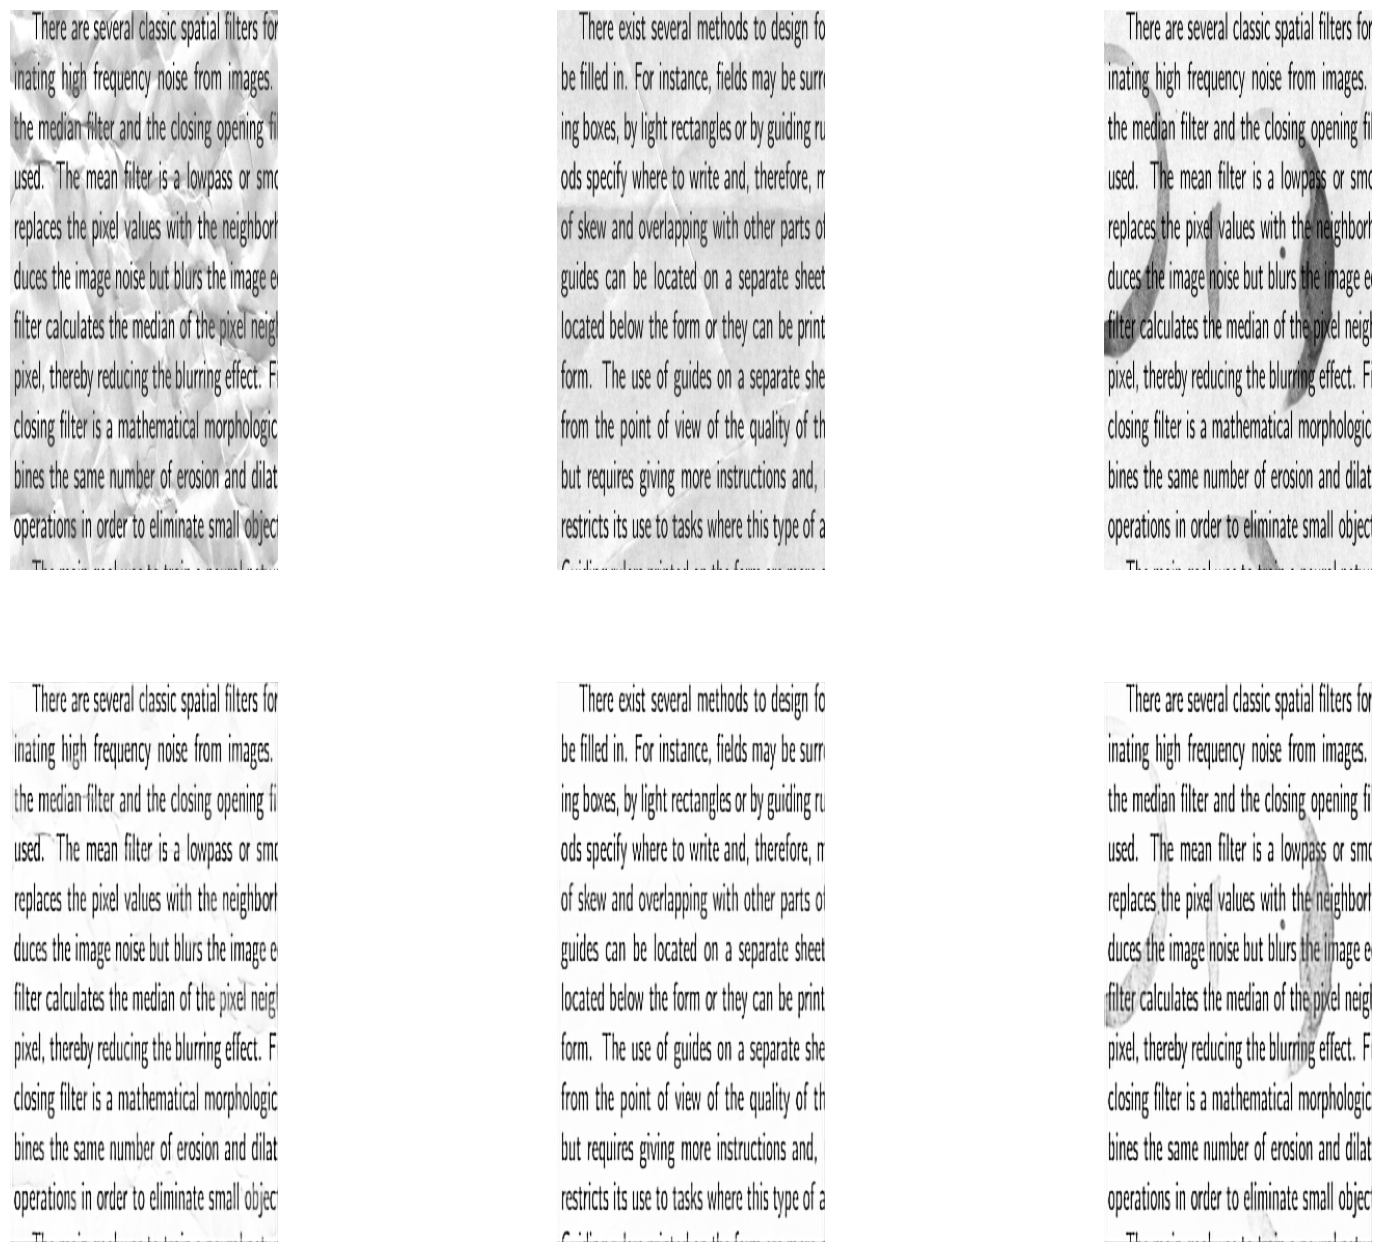

In [24]:
mostrar_imagenes(batch, y_pred)

Las imágenes ubicadas en la parte superior son las originales (con ruido) y las de la parte de abajo son las predicciones (reconstrucciones) generadas por el autoencoder.

Vemos que en algunas imágenes funciona mejor que en otras la atenuación del ruido.

Pero hasta ahora hemos hecho la prueba únicamente con imágenes conocidas (las de entrenamiento). Sin embargo, la "prueba de fuego" es verificar qué pasa cuando le presentamos al autoencoder imágenes que no ha visto hasta el momento: las imágenes de prueba.

Así que tomemos el set de prueba y usemos el mismo procedimiento anterior para generar y visualizar las predicciones:

1/1 [==============================] - 0s 50ms/step


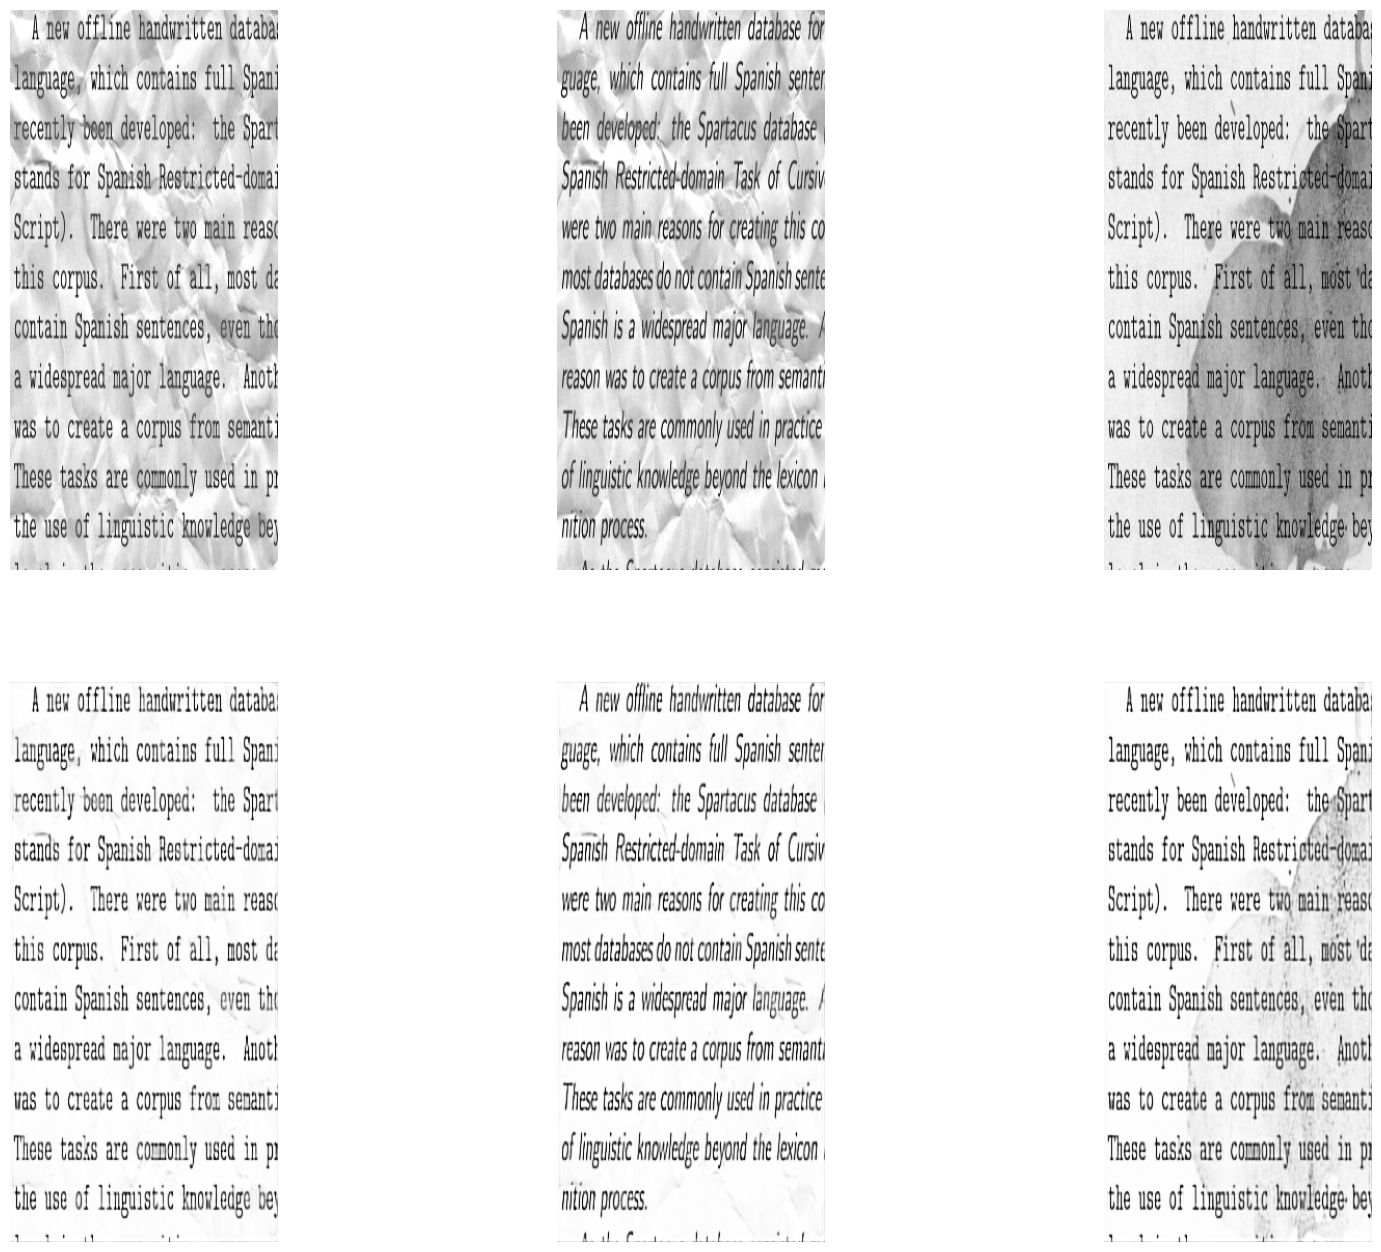

In [25]:
# Tomar un batch del set de prueba
batch = test.take(1)

# Convertir el batch a arreglo NumPy
batch = np.array(list(batch.unbatch().as_numpy_iterator()))

# Generar predicciones y visualizarlas
y_pred = autoencoder.predict(batch)
mostrar_imagenes(batch, y_pred)

Y vemos un comportamiento similar al obtenido con los datos de entrenamiento.

Así que en general podemos ver que el modelo entrenado funciona bastante bien y permite eliminar el ruido en varios tipos de imagen y reducirlo en otras.